In [96]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor
import catboost
%matplotlib inline

In [16]:
train = pd.read_csv('last_train.csv')
test = pd.read_csv('last_test.csv')

In [17]:
train.head()

,air_store_id,visit_date,visitors_x,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,rs1_x,rv1_x,...,store_pop,store_genre_pop,genre_pop,store_pop_monthly,last_genre_pop,last_month_comp,last_quarter_comp,dow_pattern_2016,dom_pattern_train_x,doy_pattern_2016
0,air_ba937bf13d40fb24,2016-01-13,25,7.0,23.84375,25.0,57.0,64.0,-1.0,-1.0,...,0.030911,0.176627,0.175009,-1.000000,0.000000,-1.000000,-1.0,0.171307,0.035361,0.003502
1,air_ba937bf13d40fb24,2016-01-20,31,7.0,23.84375,25.0,57.0,64.0,-1.0,-1.0,...,0.030911,0.176627,0.175009,-1.000000,0.000000,-1.000000,-1.0,0.171307,0.035811,0.004343
2,air_ba937bf13d40fb24,2016-01-27,24,7.0,23.84375,25.0,57.0,64.0,-1.0,-1.0,...,0.030911,0.176627,0.175009,-1.000000,0.000000,-1.000000,-1.0,0.171307,0.032443,0.003362
3,air_ba937bf13d40fb24,2016-02-03,18,7.0,23.84375,25.0,57.0,64.0,-1.0,-1.0,...,0.030911,0.176627,0.175009,0.046837,0.121377,0.385882,-1.0,0.171307,0.033004,0.002522
4,air_ba937bf13d40fb24,2016-02-10,32,7.0,23.84375,25.0,57.0,64.0,-1.0,-1.0,...,0.030911,0.176627,0.175009,0.046837,0.121377,0.385882,-1.0,0.171307,0.035923,0.004483


In [18]:
train.drop('visitors_x',axis=1,inplace=True)
train.rename(columns={'visitors_y':'visitors'},inplace=True)
test.drop('visitors_x',axis=1,inplace=True)
test.rename(columns={'visitors_y':'visitors'},inplace=True)

In [19]:
gen_e = OneHotEncoder()
gen_e.fit(np.array(list(set(train.gen))).reshape(-1,1))
area_e = OneHotEncoder()
area_e.fit(np.array(list(set(train.area))).reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [20]:
train_gen_df = pd.DataFrame(gen_e.transform(train.gen.values.reshape(-1,1)).toarray())
test_gen_df = pd.DataFrame(gen_e.transform(test.gen.values.reshape(-1,1)).toarray())
train_area_df = pd.DataFrame(area_e.transform(train.area.values.reshape(-1,1)).toarray())
test_area_df = pd.DataFrame(area_e.transform(test.area.values.reshape(-1,1)).toarray())

In [21]:
train_gen_df.columns,test_gen_df.columns,train_area_df.columns,test_area_df.columns

(RangeIndex(start=0, stop=14, step=1),
 RangeIndex(start=0, stop=14, step=1),
 RangeIndex(start=0, stop=103, step=1),
 RangeIndex(start=0, stop=103, step=1))

In [22]:
train_gen_df.columns = ['gen'+str(x) for x in train_gen_df.columns]
test_gen_df.columns = ['gen'+str(x) for x in test_gen_df.columns]
train_area_df.columns = ['area'+str(x) for x in train_area_df.columns]
test_area_df.columns = ['area'+str(x) for x in test_area_df.columns]

In [23]:
train = pd.concat([train.drop(['area','gen'],axis=1),train_gen_df,train_area_df],axis=1)
test = pd.concat([test.drop(['area','gen'],axis=1),test_gen_df,test_area_df],axis=1)

In [24]:
len(set(train.date_int))
val_key = train.date_int.apply(lambda x: True if x >= 20170321 else False)
train_key = train.date_int.apply(lambda x:True if x < 20170321 else False)

In [25]:
vtrain = train[train_key]
vval = train[val_key]

In [26]:
vtrain.shape,vval.shape

((226722, 162), (23746, 162))

## start xgb

In [27]:
dtest = xgb.DMatrix(test.drop(['id','visitors','air_store_id','visit_date'
                                     ],axis=1))
dvval = xgb.DMatrix(vval.drop(['id','visitors','air_store_id','visit_date'
                                     ],axis=1))
dvtrain = xgb.DMatrix(vtrain.drop(['id','visitors','air_store_id','visit_date'
                                     ],axis=1),vtrain.visitors.apply(np.log1p))
dtrain = xgb.DMatrix(train.drop(['id','visitors','air_store_id','visit_date'
                                     ],axis=1),train.visitors.apply(np.log1p))

## skip from here

In [54]:
dtrain = xgb.DMatrix(train.drop(['id','visitors','air_store_id','visit_date'
                                     ],axis=1),train.visitors.apply(np.log1p))
for i in np.arange(0.1,0.5,0.05):
    param = {
        'eta':i,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':29,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

0.1 0.307145333333
0.15 0.277604


KeyboardInterrupt: 

## tunning 

In [18]:
# eta
for i in np.arange(0.16,0.22,0.01):
    param = {
        'eta':i,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':29,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

0.16 0.485935666667
0.17 0.485417333333
0.18 0.485294333333
0.19 0.485689333333
0.2 0.485862666667
0.21 0.486237


In [19]:
# min child weight
for i in np.arange(25,35,1):
    param = {
        'eta':0.18,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':i,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

25 0.485397
26 0.485315666667
27 0.485564
28 0.485627
29 0.485294333333
30 0.485654666667
31 0.485214
32 0.485096333333
33 0.485287
34 0.484988


In [20]:
for i in np.arange(35,38,1):
    param = {
        'eta':0.18,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':i,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

35 0.484850666667
36 0.485177666667
37 0.484614333333


In [21]:
for i in np.arange(39,42,1):
    param = {
        'eta':0.18,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':i,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

39 0.484933
40 0.484920666667
41 0.485232333333


In [24]:
for i in np.arange(80,200,10):
    param = {
        'eta':0.18,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':i
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

80 0.484967333333
90 0.485327
100 0.485211
110 0.485059
120 0.48507
130 0.485340333333
140 0.485403
150 0.484614333333
160 0.485362333333
170 0.485246
180 0.485148333333
190 0.485207333333


In [25]:
for i in np.arange(141,152,1):
    param = {
        'eta':0.18,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':i
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

141 0.485011
142 0.484914333333
143 0.485591
144 0.485305333333
145 0.485095
146 0.485213333333
147 0.485293
148 0.484877
149 0.485296
150 0.484614333333
151 0.484926


In [26]:
for i in np.arange(0.7,1,0.05):
    for j in np.arange(0.7,1,0.05):
        param = {
            'eta':0.18,'max_depth':16,'subsample':i,'colsample_bytree':j,'lamdba':0.3,'alpha':0.8,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
        }
        hist = xgb.cv(param,dtrain,30,metrics='rmse')
        print(i,j,hist['test-rmse-mean'].iloc[-1])

0.7 0.7 0.486201333333
0.7 0.75 0.486024333333
0.7 0.8 0.486316
0.7 0.85 0.486374
0.7 0.9 0.485943333333
0.7 0.95 0.486025333333
0.7 1.0 0.485818666667
0.75 0.7 0.486210333333
0.75 0.75 0.485908333333
0.75 0.8 0.486296
0.75 0.85 0.486074
0.75 0.9 0.486158666667
0.75 0.95 0.485779
0.75 1.0 0.485745333333
0.8 0.7 0.486064666667
0.8 0.75 0.48583
0.8 0.8 0.485734333333
0.8 0.85 0.485532333333
0.8 0.9 0.485664333333
0.8 0.95 0.485473666667
0.8 1.0 0.485992333333
0.85 0.7 0.485864666667
0.85 0.75 0.485765333333
0.85 0.8 0.485901
0.85 0.85 0.485109666667
0.85 0.9 0.485195
0.85 0.95 0.485277
0.85 1.0 0.485122666667
0.9 0.7 0.485344666667
0.9 0.75 0.485296666667
0.9 0.8 0.485528666667
0.9 0.85 0.485494
0.9 0.9 0.484926666667
0.9 0.95 0.485077333333
0.9 1.0 0.485125333333
0.95 0.7 0.485293666667
0.95 0.75 0.485143666667
0.95 0.8 0.485034666667
0.95 0.85 0.485011
0.95 0.9 0.484867333333
0.95 0.95 0.484746
0.95 1.0 0.485259
1.0 0.7 0.485438666667
1.0 0.75 0.485214666667
1.0 0.8 0.485312333333
1.0 

In [27]:
for i in np.arange(0.9,1,0.01):
    for j in np.arange(0.7,1,0.03):
        param = {
            'eta':0.18,'max_depth':16,'subsample':i,'colsample_bytree':j,'lamdba':0.3,'alpha':0.8,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
        }
        hist = xgb.cv(param,dtrain,30,metrics='rmse')
        print(i,j,hist['test-rmse-mean'].iloc[-1])

0.9 0.7 0.485344666667
0.9 0.73 0.485239
0.9 0.76 0.485503333333
0.9 0.79 0.485447666667
0.9 0.82 0.48592
0.9 0.85 0.485494
0.9 0.88 0.485302333333
0.9 0.91 0.484979333333
0.9 0.94 0.484912333333
0.9 0.97 0.484983
0.9 1.0 0.485125333333
0.91 0.7 0.485313666667
0.91 0.73 0.484976666667
0.91 0.76 0.485063666667
0.91 0.79 0.485553333333
0.91 0.82 0.485225666667
0.91 0.85 0.485148666667
0.91 0.88 0.484789666667
0.91 0.91 0.484848666667
0.91 0.94 0.484924666667
0.91 0.97 0.485783666667
0.91 1.0 0.484651333333
0.92 0.7 0.485342333333
0.92 0.73 0.485165
0.92 0.76 0.485655333333
0.92 0.79 0.485350333333
0.92 0.82 0.484730666667
0.92 0.85 0.485456333333
0.92 0.88 0.485019666667
0.92 0.91 0.485436333333
0.92 0.94 0.48528
0.92 0.97 0.484995
0.92 1.0 0.484800333333
0.93 0.7 0.485350666667
0.93 0.73 0.485439
0.93 0.76 0.485379333333
0.93 0.79 0.485197666667
0.93 0.82 0.484941
0.93 0.85 0.485518333333
0.93 0.88 0.485166666667
0.93 0.91 0.484866666667
0.93 0.94 0.485050666667
0.93 0.97 0.484759
0.93 

In [28]:
for i in [0.98,0.95,0.94]:
    for j in [0.81,0.82,0.84,0.93,0.95,0.92]:
        param = {
            'eta':0.18,'max_depth':16,'subsample':i,'colsample_bytree':j,'lamdba':0.3,'alpha':0.8,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
        }
        hist = xgb.cv(param,dtrain,30,metrics='rmse')
        print(i,j,hist['test-rmse-mean'].iloc[-1])

0.98 0.81 0.485118
0.98 0.82 0.485315
0.98 0.84 0.485382
0.98 0.93 0.48485
0.98 0.95 0.484915666667
0.98 0.92 0.484672
0.95 0.81 0.485296666667
0.95 0.82 0.484665333333
0.95 0.84 0.484998333333
0.95 0.93 0.484794333333
0.95 0.95 0.484746
0.95 0.92 0.484392666667
0.94 0.81 0.485542333333
0.94 0.82 0.485119333333
0.94 0.84 0.485367666667
0.94 0.93 0.484912666667
0.94 0.95 0.484831333333
0.94 0.92 0.484865


In [31]:
for j in np.arange(0.85,0.95,0.01):
    param = {
            'eta':0.18,'max_depth':16,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':j,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,30,metrics='rmse')
    print(j,hist['test-rmse-mean'].iloc[-1])

0.85 0.485139
0.86 0.484587
0.87 0.484552
0.88 0.484733
0.89 0.484572
0.9 0.484040333333
0.91 0.48485
0.92 0.484506
0.93 0.484225
0.94 0.484413333333


In [58]:
for j in np.arange(3,20,1):
    param = {
            'eta':0.18,'max_depth':j,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,100,metrics='rmse')
    print(j,hist['test-rmse-mean'].iloc[-1])

3 0.302710333333
4 0.288521666667
5 0.279879666667
6 0.275520333333
7 0.272027666667
8 0.26981
9 0.268912
10 0.268429333333
11 0.268654333333
12 0.269368333333
13 0.269845
14 0.271134


KeyboardInterrupt: 

In [94]:
for j in np.arange(0.01,0.04,0.01):
    param = {
            'eta':j,'max_depth':10,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':37,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dtrain,2000,metrics='rmse')
    print(j,hist['test-rmse-mean'].iloc[-1])

KeyboardInterrupt: 

## start from here

In [28]:
features3 = pd.read_csv('3features.csv')

In [29]:
train = pd.merge(train,features3,how='left',on='id')
test = pd.merge(test,features3,how='left',on='id')
vtrain = pd.merge(vtrain,features3,how='left',on='id')
vval = pd.merge(vval,features3,how='left',on='id')

In [30]:
def new_holi(data):
    if data.holi==1 or data.dow==5 or data.dow==6:
        return 1
    else:
        return 0

In [31]:
train['new_holi'] = train.apply(new_holi,axis=1)
test['new_holi'] = test.apply(new_holi,axis=1)
vtrain['new_holi'] = vtrain.apply(new_holi,axis=1)
vval['new_holi'] = vval.apply(new_holi,axis=1)

In [32]:
train.columns[:50]

Index(['air_store_id', 'visit_date', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations', 'rs1_x',
       'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'id',
       'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
       'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'dom', 'doq',
       'dow', 'doy', 'holi', 'month', 'quarter', 'store', 'visitors', 'year',
       'last_quarter_gen_pop', 'last_quarter_s_pop', 'store_pop',
       'store_genre_pop', 'genre_pop', 'store_pop_monthly', 'last_genre_pop',
       'last_month_comp', 'last_quarter_comp', 'dow_pattern_2016',
       'dom_pattern_train_x', 'doy_pattern_2016', 'gen0', 'gen1', 'gen2',
       'gen3', 'gen4'],
      dtype='object')

In [33]:
drop_col = ['id','visitors','air_store_id','visit_date',
            'store_pop','store_genre_pop', 'genre_pop',
            'holi_mean', 'nonholi_mean',
           'dow_pattern_2016','dom_pattern_train_x', 'doy_pattern_2016']

In [34]:
dtrain = xgb.DMatrix(train.drop(drop_col,axis=1),train.visitors.apply(np.log1p))
dtest = xgb.DMatrix(test.drop(drop_col,axis=1))
dvval = xgb.DMatrix(vval.drop(drop_col,axis=1))
dvtrain = xgb.DMatrix(vtrain.drop(drop_col,axis=1),vtrain.visitors.apply(np.log1p))

In [35]:
for i in np.arange(0.1,0.2,0.05):
    param = {
        'eta':i,'max_depth':16,'subsample':0.94,'colsample_bytree':0.73,'lamdba':0.3,'alpha':0.8,\
        'min_child_weight':29,'num_boost_round':100,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dvtrain,30,metrics='rmse')
    print(i,hist['test-rmse-mean'].iloc[-1])

0.1 0.507782
0.15 0.495538333333


In [112]:
train.columns[:50]

Index(['air_store_id', 'visit_date', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations', 'rs1_x',
       'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'id',
       'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
       'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'dom', 'doq',
       'dow', 'doy', 'holi', 'month', 'quarter', 'store', 'visitors', 'year',
       'last_quarter_gen_pop', 'last_quarter_s_pop', 'store_pop',
       'store_genre_pop', 'genre_pop', 'store_pop_monthly', 'last_genre_pop',
       'last_month_comp', 'last_quarter_comp', 'dow_pattern_2016',
       'dom_pattern_train_x', 'doy_pattern_2016', 'gen0', 'gen1', 'gen2',
       'gen3', 'gen4'],
      dtype='object')

In [130]:
#'last_quarter_gen_pop', 'last_quarter_s_pop','last_month_comp', 'last_quarter_comp','store_pop_monthly','store_pop',
dvval = xgb.DMatrix(vval.drop(['id','visitors','air_store_id','visit_date'
                              ,'holi_mean', 'nonholi_mean',
                              'dow_pattern_2016',
                              'dom_pattern_train_x', 'doy_pattern_2016' 
                              ],axis=1))
dvtrain = xgb.DMatrix(vtrain.drop(['id','visitors','air_store_id','visit_date'
                                   ,'holi_mean', 'nonholi_mean',
                                  'dow_pattern_2016',
                                  'dom_pattern_train_x', 'doy_pattern_2016'
                                  ],axis=1),vtrain.visitors.apply(np.log1p))

In [40]:
def rmsle(y,preds):
    return np.sqrt(np.mean(np.power((y-preds),2)))

In [41]:
param = {
            'eta':0.01,'max_depth':10,'subsample':0.85,'colsample_bytree':0.75,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':22,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':180
    }
bst = xgb.train(param,dvtrain,300)
preds = bst.predict(dvval)
print(rmsle(vval.visitors.apply(np.log1p),preds))

0.506680630714


In [48]:
bst_eta = 0.03
rs = 0.9
for i in np.arange(0.03,0.1,0.01):
    param = {
        'eta':i,'max_depth':10,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':0.9,\
        'min_child_weight':37,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dvtrain,300,metrics='rmse')['test-rmse-mean'].iloc[-1]
    print(i,hist)
    if hist<rs:
        bst_eta = i
        rs = hist
rs_eta = rs
print('=====')
print(bst_eta,rs_eta)

0.03 0.490273333333
0.04 0.489056
0.05 0.488359333333
0.06 0.488029666667
0.07 0.488181666667
0.08 0.488254333333
0.09 0.489037666667
0.1 0.489214
=====
0.06 0.488029666667


In [49]:
bst_child = 37
rs = rs_eta
for i in np.arange(20,40,1):
    param = {
        'eta':bst_eta,'max_depth':10,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':0.9,\
        'min_child_weight':i,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
    hist = xgb.cv(param,dvtrain,300,metrics='rmse')['test-rmse-mean'].iloc[-1]
    print(i,hist)
    if hist<rs:
        bst_child=i
        rs = hist
rs_child = rs
print('=====')
print(bst_child,rs_child)

20 0.487928333333
21 0.488024333333
22 0.488072333333
23 0.487992666667
24 0.487982
25 0.488077666667
26 0.488001666667
27 0.487972333333
28 0.488232333333
29 0.488173
30 0.488090666667
31 0.488198333333
32 0.488092666667
33 0.488201333333
34 0.487908
35 0.488019666667
36 0.487957666667
37 0.488029666667
38 0.488132666667
39 0.488354333333
=====
34 0.487908


In [51]:
bst_bin = 150
rs = rs_child
for i in np.arange(80,200,20):
    param = {
        'eta':bst_eta,'max_depth':10,'subsample':0.98,'colsample_bytree':0.94,'lamdba':0.3,'alpha':0.9,\
        'min_child_weight':bst_child,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':i
    }
    hist = xgb.cv(param,dvtrain,300,metrics='rmse')['test-rmse-mean'].iloc[-1]
    print(i,hist)
    if hist<rs:
        bst_bin=i
        rs = hist
rs_bin = rs
print('=====')
print(bst_bin,rs_bin)

80 0.488260666667
100 0.488222333333
120 0.487990666667
140 0.488113666667
160 0.488091333333
180 0.488117333333
=====
150 0.487908


In [58]:
bst_ss = 0.98
bst_cs = 0.94
rs = rs_bin
for i in np.arange(0.75,0.95,0.02):
    for j in np.arange(0.75,0.95,0.02):
        param = {
            'eta':bst_eta,'max_depth':10,'subsample':i,'colsample_bytree':j,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':bst_child,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':bst_bin
        }
        hist = xgb.cv(param,dvtrain,300,metrics='rmse')['test-rmse-mean'].iloc[-1]
        print(i,j,hist)
        if hist<rs:
            bst_ss = i
            bst_cs = j
            rs = hist
rs_sscs = rs
print('=====')
print(bst_ss,bst_cs,rs_sscs)

0.75 0.75 0.488006
0.75 0.77 0.487971
0.75 0.79 0.487966666667
0.75 0.81 0.488034333333
0.75 0.83 0.487984333333
0.75 0.85 0.487988666667
0.75 0.87 0.487983666667
0.75 0.89 0.488226666667
0.75 0.91 0.488030666667
0.75 0.93 0.488020666667
0.77 0.75 0.487956333333
0.77 0.77 0.488072333333
0.77 0.79 0.487906
0.77 0.81 0.487894333333
0.77 0.83 0.487974
0.77 0.85 0.487918333333
0.77 0.87 0.488146666667
0.77 0.89 0.488120333333
0.77 0.91 0.487973
0.77 0.93 0.488048333333
0.79 0.75 0.487959333333
0.79 0.77 0.487927333333
0.79 0.79 0.488073
0.79 0.81 0.487863333333
0.79 0.83 0.487906
0.79 0.85 0.487973
0.79 0.87 0.487893666667
0.79 0.89 0.487877333333
0.79 0.91 0.488010333333
0.79 0.93 0.487926666667
0.81 0.75 0.487874333333
0.81 0.77 0.487850666667
0.81 0.79 0.487944666667
0.81 0.81 0.488012
0.81 0.83 0.487929666667
0.81 0.85 0.487966
0.81 0.87 0.487717
0.81 0.89 0.487981
0.81 0.91 0.487934333333
0.81 0.93 0.487965666667
0.83 0.75 0.487870666667
0.83 0.77 0.487874333333
0.83 0.79 0.4877863333

In [53]:
bst_depth = 10
rs = rs_sscs
for i in np.arange(6,20,1):
    param = {
            'eta':bst_eta,'max_depth':i,'subsample':bst_ss,'colsample_bytree':bst_cs,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':bst_child,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':bst_bin
        }
    hist = xgb.cv(param,dvtrain,300,metrics='rmse')['test-rmse-mean'].iloc[-1]
    print(i,hist)
    if hist<rs:
        bst_depth = i
        rs = hist
rs_depth = rs
print('=====')
print(bst_depth,rs_depth)

6 0.492977333333
7 0.490644333333
8 0.48896
9 0.487891666667
10 0.487553333333
11 0.488194
12 0.488769333333
13 0.490009333333
14 0.491033666667
15 0.492576333333
16 0.494379666667
17 0.495993
18 0.497625666667
19 0.498671
=====
10 0.487553333333


In [59]:
param = {
            'eta':bst_eta,'max_depth':bst_depth,'subsample':bst_ss,'colsample_bytree':bst_cs,'lamdba':0.3,'alpha':0.9,\
            'min_child_weight':bst_child,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
            'tree_method':'hist','max_bin':bst_bin
    }
bst = xgb.train(param,dvtrain,300)
preds = bst.predict(dvval)
print(rmsle(vval.visitors.apply(np.log1p),preds))

0.494181712551


In [60]:
param = {
        'eta':bst_eta,'max_depth':bst_depth,'subsample':bst_ss,'colsample_bytree':bst_cs,'lamdba':0.3,'alpha':0.9,\
        'min_child_weight':bst_child,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':bst_bin
    }
bst = xgb.train(param,dtrain,300)
preds = bst.predict(dtest)
result = pd.concat([test[['id']].reset_index(drop=True),pd.Series(np.expm1(preds),name='visitors')],axis=1)

In [61]:
result.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.223294
1,air_00a91d42b08b08d9_2017-04-24,18.816980
2,air_00a91d42b08b08d9_2017-04-25,23.970587
3,air_00a91d42b08b08d9_2017-04-26,29.230278
4,air_00a91d42b08b08d9_2017-04-27,31.785595


In [62]:
result.to_csv('./subs/sub300r.csv',index=False)

## catboost

In [74]:
pool = catboost.Pool(vtrain.drop(['id','visitors','air_store_id','visit_date'
                                   ,'holi_mean', 'nonholi_mean',
                                  'dow_pattern_2016',
                                  'dom_pattern_train_x', 'doy_pattern_2016'
                                  ],axis=1),vtrain.visitors.apply(np.log1p))
train_pool = catboost.Pool(train.drop(drop_col,axis=1),train.visitors.apply(np.log1p))
test_pool = catboost.Pool(test.drop(drop_col,axis=1))

In [52]:
for i in np.arange(0.05,0.6,0.05):
    param_cat = {'iterations': 300, 'depth': 8, 'loss_function': 'RMSE','logging_level': 'Silent',
             'learning_rate':i}
    print(i,catboost.cv(params=param_cat,pool=pool)['RMSE_test_avg'][-1])

0.05 0.49940249849972335
0.1 0.4946393970882652
0.15 0.49247099034700414
0.2 0.491381681592384
0.25 0.4906182252386251
0.3 0.49100669062455865
0.35 0.4908675030704283
0.4 0.4915717068554502
0.45 0.49277033049957364
0.5 0.4932182986791955
0.55 0.494161747948939


In [71]:
for i in np.arange(6,16,1).tolist():
    param_cat = {'iterations': 300, 'depth': i, 'loss_function': 'RMSE','logging_level': 'Silent',
             'learning_rate':0.25}
    print(i,catboost.cv(params=param_cat,pool=pool)['RMSE_test_avg'][-1])

6 0.49337523204953193
7 0.49196130374369
8 0.49094420224646124
9 0.49004943989390554
10 0.48963997804781617
11 0.4895608587001807
12 0.48939564377409045
13 0.4895885011545849
14 0.48956469805133923
15 0.4899796161383367


In [78]:
catboost.train?

In [79]:
cat_param = {'iterations': 300, 'depth': 12, 'loss_function': 'RMSE','logging_level': 'Silent',
             'learning_rate':0.25}
cat = catboost.train(pool=train_pool,params=cat_param,iterations=300)

In [85]:
preds = cat.predict(test_pool)
result_cat = pd.concat([test[['id']].reset_index(drop=True),pd.Series(np.expm1(preds),name='visitors_cat')],axis=1)

In [86]:
result_cat.head()

,id,visitors_cat
0,air_00a91d42b08b08d9_2017-04-23,3.721075
1,air_00a91d42b08b08d9_2017-04-24,19.788363
2,air_00a91d42b08b08d9_2017-04-25,20.599477
3,air_00a91d42b08b08d9_2017-04-26,29.202041
4,air_00a91d42b08b08d9_2017-04-27,32.146994


In [82]:
result.to_csv('./subs/sub300r.csv',index=False)

## ensemble cat and xgb

In [84]:
param = {
        'eta':0.06,'max_depth':10,'subsample':0.91,'colsample_bytree':0.77,'lamdba':0.3,'alpha':0.9,\
        'min_child_weight':34,'num_boost_round':300,'objective':'reg:linear','booster':'gbtree',\
        'tree_method':'hist','max_bin':150
    }
bst = xgb.train(param,dtrain,300)
preds_xgb = bst.predict(dtest)
result_xgb = pd.concat([test[['id']].reset_index(drop=True),pd.Series(np.expm1(preds_xgb),name='visitors_xgb')],axis=1)

In [87]:
result_xgb.head()

,id,visitors_xgb
0,air_00a91d42b08b08d9_2017-04-23,2.223294
1,air_00a91d42b08b08d9_2017-04-24,18.816980
2,air_00a91d42b08b08d9_2017-04-25,23.970587
3,air_00a91d42b08b08d9_2017-04-26,29.230278
4,air_00a91d42b08b08d9_2017-04-27,31.785595


In [88]:
result = pd.merge(result_xgb,result_cat,how='inner',on='id')

In [92]:
result['visitors'] = result['visitors_xgb']*0.6 + result['visitors_cat']*0.4

In [93]:
result.head()

,id,visitors_xgb,visitors_cat,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.223294,3.721075,2.822406
1,air_00a91d42b08b08d9_2017-04-24,18.816980,19.788363,19.205533
2,air_00a91d42b08b08d9_2017-04-25,23.970587,20.599477,22.622143
3,air_00a91d42b08b08d9_2017-04-26,29.230278,29.202041,29.218983
4,air_00a91d42b08b08d9_2017-04-27,31.785595,32.146994,31.930154


In [94]:
result[['id','visitors']].to_csv('cat_xgb.csv',index=False)

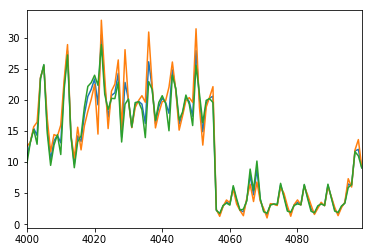

In [101]:
result.iloc[4000:4100].visitors.plot();
result.iloc[4000:4100].visitors_cat.plot();
result.iloc[4000:4100].visitors_xgb.plot();

# lightgbm

In [131]:
param_lgb = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
}
vtrain_lgb = lgb.Dataset(vtrain.drop(['id','visitors','air_store_id','visit_date'
                                   ,'holi_mean', 'nonholi_mean',
                                  'dow_pattern_2016',
                                  'dom_pattern_train_x', 'doy_pattern_2016'
                                  ],axis=1),vtrain.visitors.apply(np.log1p))

In [134]:
lgb.cv(params=param_lgb,train_set=vtrain_lgb,shuffle=False,num_boost_round=300,
       metrics='rsme',stratified=False)

{}

In [129]:
lgb_model = lgb.train(params=param_lgb,train_set=vtrain_lgb)
lgb_model.predict(test.drop(drop_col,axis=1))

array([ 1.2732476 ,  2.7678591 ,  2.93612149, ...,  1.68900961,
        1.71955372,  1.71955372])

In [130]:
lgb.cv?